# Portfolio Optimization

*This was taken from https://blog.quantopian.com/markowitz-portfolio-optimization-2/*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing
solvers.options['show_progress'] = False

In [2]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0,0.5,'returns')

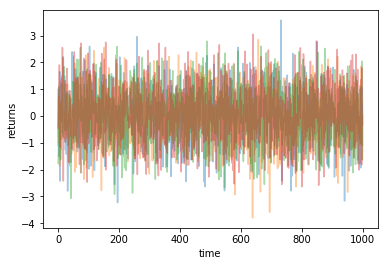

In [3]:
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1'''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [5]:
def random_portfolio(returns):
    '''
    Returns the mean and the standard deviation of returns for a random portfolio
    '''
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

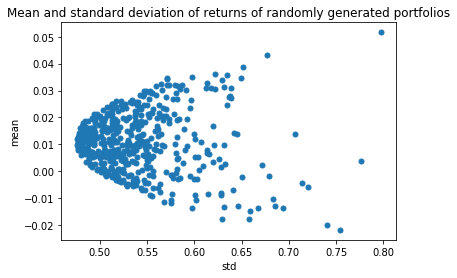

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

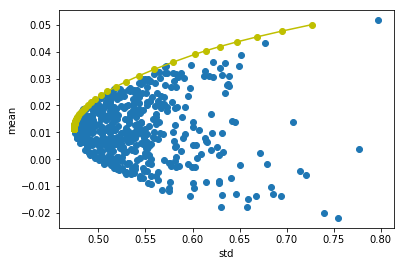

In [71]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios

weights, returns, risks, portfolios = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')


In [87]:
newportfolios = []
for portfolio in portfolios:
    portfolio = np.asmatrix(portfolio)
    newportfolios.append(portfolio)
portfolios = newportfolios

In [105]:
port = portfolios[-1]
risk = np.sqrt(np.dot(port.T,np.dot(np.cov(return_vec),port)))
rm = np.dot(np.mean(return_vec,axis=1),port)
print(risk, rm)

[[0.47394755]] [[0.01127344]]
